In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.style.use('base')

import scipy as sp
from scipy import optimize
from scipy import stats
from scipy.constants import physical_constants

from pandas import DataFrame
import sympy as sym
import pyfraecx as skx

from IPython.display import display, display_latex
import IPython
import os
import sys
import warnings

formats = ['png']
dpi_value= 300

F = physical_constants['Faraday constant'][0]
R = physical_constants['molar gas constant'][0]
k = physical_constants['Boltzmann constant'][0]
e = physical_constants['elementary charge'][0]

kTe280 = k*(273.15+280.0)/e*1000.0
print(kTe280)

C:\Users\mskocic\.pyfraecx\pyfraecx.ini
47.66677893955605


In [2]:
IPython.__version__

'9.6.0'

In [3]:
FORMATS = ['png']
DPI = 300


In [4]:
def tafel_metal(E, OCV=0.0, j0=1.0e-6, alpha_a=0.5, alpha_c=0.5, z=1, S=1, T=25.0):
    
    F = 96485.3365
    R = 8.3144621
    T_K = 273.15+T
    n = E-OCV
    Ia = j0*S*np.exp((F*alpha_a*z*(E-OCV))/(R*T_K))
    Ic = -j0*S*np.exp(-(F*alpha_c*z*(E-OCV))/(R*T_K))
    I = Ia+Ic
    return I, Ia, Ic

# Tafel Plot

In [5]:
%%latex
The Tafel slopes can be obtained by rewritting the Butler-Volmer equation and neglecting the mass transport.
The equation \ref{eq:tafel_normal} gives the expression of the net current which is formed of the anodic and cathodic
contributions.

\begin{equation}
    \begin{split}
         j &= j_0 \left[ \exp\left(\frac{\alpha_{r} z_{r} F}{RT}\right) - \exp\left(\frac{\alpha _{o}z_{o}F}{RT}\right) \right]\\
           &= j_0 \left[ \exp\left(\frac{\alpha_{r} z_{r}}{kT/e}\right) - \exp\left(\frac{\alpha _{o}z_{o}}{kT/e}\right) \right]
    \end{split}
%\label{eq:tafel_normal}
\end{equation}

\begin{equation}
         \frac{RT}{F} = \frac{kT}{e} =
          \begin{cases}
            25.69 \, \text{mV} & \text{à 25°C}\\
            47.67 \, \text{mV} & \text{à 280°C}
          \end{cases}
\end{equation}

<IPython.core.display.Latex object>

In [6]:
E = np.linspace(-500, 500, 5000)
OCV = 0.0
alpha_a = 0.5
alpha_c = 0.5
z=1.0
S=1.0
T=280.0
j0 = 1e-6
jla = j0 * 200
jlc = -j0 * 200


I_tafel, Ia, Ic, *opt = skx.kinetics.buttler_volmer_mass(E/1000.0, j0, jla, jlc, alpha_a, alpha_c, z,z, S, T)
_I_tafel, Ia, Ic, *opt = skx.kinetics.buttler_volmer(E/1000.0, j0, alpha_a, alpha_c, z,z, S, T)

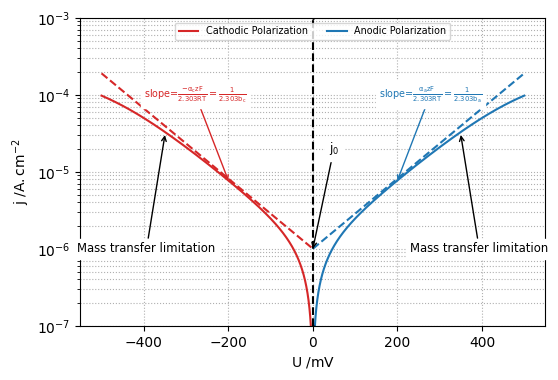

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid(which='minor', axis='y')
ax.set_xlabel(r'$U$ /mV', fontsize='medium')
ax.set_ylabel('$j$ /$A.cm^{-2}$', fontsize='medium')

ax.set_yscale('log')
ax.plot(E[E<=0], np.abs(I_tafel[E<=0]/S), 'C3-', label='Cathodic Polarization')
ax.plot(E[E>=0], np.abs(I_tafel[E>=0]/S), 'C0-', label='Anodic Polarization')

ax.plot(E[E>=0], Ia[E>=0], 'C0--')
ax.plot(E[E<=0], -Ic[E<=0], 'C3--')

ax.set_ylim(1e-7, 1e-3)
ax.axvline(x=0.0, color='k', ls='--')

ax.annotate(text=r'$j_0$', xy=(0, 1e-6), xytext=(50, 2e-5),
           arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0),
           fontsize='small',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
           va='center', ha='center');

idx = np.where(E<=+200)[0][-1]
xy = (+200, I_tafel[idx])
ax.annotate(text=r'slope=$\frac{\alpha _a z F}{2.303 RT} = \frac{1}{2.303 b_a}$',
            xy=xy, xytext=(400, 1e-4),
           arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0, color='C0'),
           fontsize='x-small',
            color='C0',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
           va='center', ha='right');

idx = np.where(E<=-200)[0][-1]
xy = (-200, -I_tafel[idx])
ax.annotate(text=r'slope=$\frac{-\alpha _c z F}{2.303 RT} = \frac{1}{2.303 b_c}$',
            xy=xy, xytext=(-400, 1e-4),
           arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0, color='C3'),
           fontsize='x-small',
            color='C3',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
           va='center', ha='left');

xy=(-350, 3e-5)
ax.annotate(text=u'Mass transfer limitation',
            xy=xy, xytext=(-230, 1e-6),
            arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0),
            fontsize='small',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
            va='center', ha='right');

xy=(+350, 3e-5)
ax.annotate(text=u'Mass transfer limitation',
            xy=xy, xytext=(+230, 1e-6),
            arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0),
            fontsize='small',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
            va='center', ha='left');

ax.legend(loc='upper center', ncol=2, fontsize='x-small')

name = 'Polarization_Curve-n'
for i in FORMATS:
    folder = '../Outputs/Plots/' + i + '/'
    ext = '.' + i
    fname = folder + name + ext
    fig.savefig(fname, dpi=300, format=i)

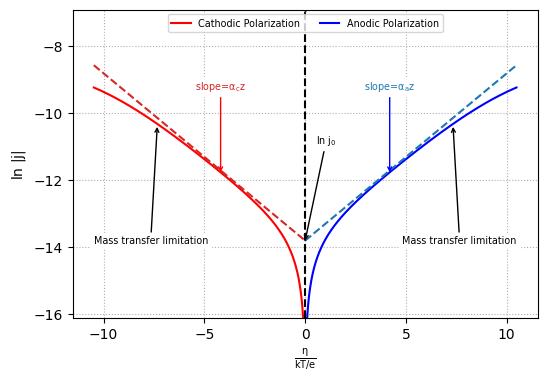

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel(r'$\frac{\eta}{kT/e}$')
ax.set_ylabel(r'$\ln \, \vert j \vert$ ')

kTe = R*(T+273.15)/F*1000

ax.plot(E[E<=0]/kTe, np.log(np.abs(I_tafel[E<=0]/S)), 'r-', label=u'Cathodic Polarization')
ax.plot(E[E>=0]/kTe, np.log(np.abs(I_tafel[E>=0]/S)), 'b-', label=u'Anodic Polarization')

ax.plot(E[E>=0]/kTe, np.log(Ia[E>=0]), 'C0--')
ax.plot(E[E<=0]/kTe, np.log(-Ic[E<=0]), 'C3--')

ax.set_ylim(np.log(1e-7), np.log(1e-3))

#ax.set_xlim(E.min()/kTe, E.max()/kTe)
ax.axvline(x=0.0, color='k', ls='--')


ax.annotate(text=r'$\ln \, j_0$', xy=(0/kTe, np.log(1e-6)), xytext=(50/kTe, np.log(2e-5)),
           arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0),
           fontsize='x-small',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
           va='center', ha='center')

idx = np.where(E<=200)[0][-1]
xy = (200/kTe, np.log(I_tafel[idx]))
ax.annotate(text=r'slope=$\alpha _{a} z$',
            xy=xy, xytext=(200/kTe, np.log(1e-4)),
           arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0,color='b'),
           fontsize='x-small',
            color='C0',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
           va='center', ha='center')

idx = np.where(E<=-200)[0][-1]
xy = (-200/kTe, np.log(-I_tafel[idx]))
ax.annotate(text=r'slope=$\alpha _{c} z$',
            xy=xy, xytext=(-200/kTe, np.log(1e-4)),
           arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0,color='r'),
           fontsize='x-small',
            color='C3',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
           va='center', ha='center')


xy=(-350/kTe, np.log(3e-5))
ax.annotate(text=u'Mass transfer limitation',
            xy=xy, xytext=(-230/kTe, np.log(1e-6)),
            arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0),
            fontsize='x-small',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
            va='center', ha='right');

xy=(+350/kTe, np.log(3e-5))
ax.annotate(text=u'Mass transfer limitation',
            xy=xy, xytext=(+230/kTe, np.log(1e-6)),
            arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0.0),
            fontsize='x-small',
            bbox=dict(boxstyle='square', ec='w', fc='w'),
            va='center', ha='left');

ax.legend(loc='upper center', ncol=2, fontsize='x-small')

name = 'Polarization_Curve-kTe'
for i in FORMATS:
    folder = '../Outputs/Plots/' + i + '/'
    ext = '.' + i
    fname = folder + name + ext
    fig.savefig(fname, dpi=DPI, format=i)

# Tafel n/p

In [9]:
E = np.linspace(-250, 250, 5000)
OCV = 0.0
an_a ,ap_a = 0.0, 1.0
an_c, ap_c = 1.0, 0.0
a_UV = 0.5
z=1.0
S=1.0
T=280.0
j0 = 1e-6

In, Ina, Inc, *opt = skx.kinetics.buttler_volmer(E/1000.0, j0, an_a, an_c, z, z, S, T)
InUV, InaUV, IncUV, *opt = skx.kinetics.buttler_volmer(E/1000.0, j0*10, a_UV, a_UV, z, z, S, T)

Ip, Ipa, Ipc, *opt = skx.kinetics.buttler_volmer(E/1000.0, j0, ap_a, ap_c, z, z, S, T)
IpUV, IpaUV, IpcUV,*opt = skx.kinetics.buttler_volmer(E/1000.0, j0*10, a_UV, a_UV, z, z, S, T)

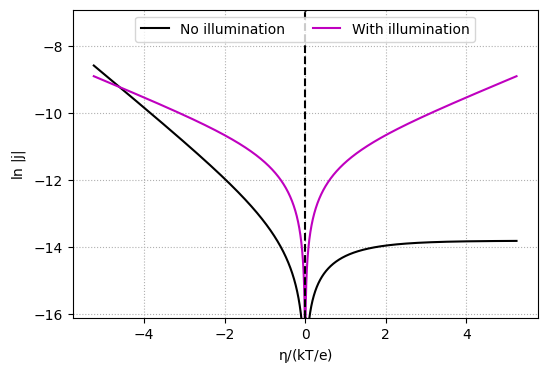

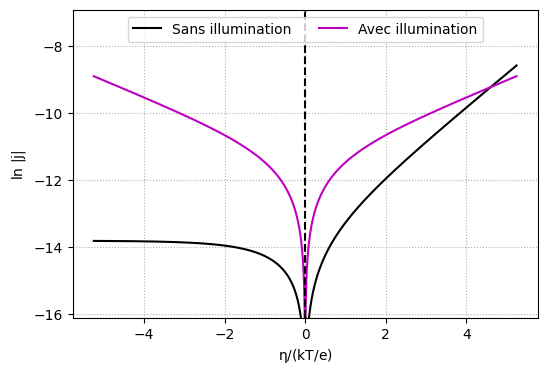

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid(which='minor', axis='y')
ax.set_xlabel(r'$\eta /(kT/e)$')
ax.set_ylabel(r'$\ln \, \vert j \vert$ ')

ax.plot(E/kTe, np.log(np.abs(In/S)), 'k-', label='No illumination')
ax.plot(E/kTe, np.log(np.abs(InUV/S)), 'm-', label='With illumination')


ax.set_ylim(np.log(1e-7), np.log(1e-3))
ax.axvline(x=0.0, color='k', ls='--')

ax.legend(loc='upper center', ncol=2)

name = 'Polarization_Curve-ntype'
for i in FORMATS:
    folder = '../Outputs/Plots/' + i + '/'
    ext = '.' + i
    fname = folder + name + ext
    fig.savefig(fname, dpi=DPI, format=i)




fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid(which='minor', axis='y')
ax.set_xlabel(r'$\eta / (kT/e)$')
ax.set_ylabel(r'$\ln \, \vert j \vert$ ')


ax.plot(E/kTe, np.log(np.abs(Ip/S)), 'k-', label='Sans illumination')
ax.plot(E/kTe, np.log(np.abs(IpUV/S)), 'm-', label='Avec illumination')

ax.set_ylim(np.log(1e-7), np.log(1e-3))
ax.axvline(x=0.0, color='k', ls='--')

ax.legend(loc='upper center', ncol=2)

name = 'Polarization_Curve-ptype'
for i in FORMATS:
    folder = '../Outputs/Plots/' + i + '/'
    ext = '.' + i
    fname = folder + name + ext
    fig.savefig(fname, dpi=DPI, format=i)

# Galvanic coupling

In [11]:
E = np.linspace(-500, 500, 5000)
OCV = -400
alpha_a = 0.5
alpha_c = 0.5
z=1.0
S=1.0
T=280.0
j0 = 1e-6
jla = j0 * 200
jlc = -j0 * 200

I_tafel1, Ia, Ic, *opt = skx.kinetics.buttler_volmer((E-OCV)/1000.0, j0, alpha_a, alpha_c, z,z, S, T)

OCV = 400.0
I_tafel2, Ia, Ic, *opt = skx.kinetics.buttler_volmer((E-OCV)/1000.0, j0, alpha_a, alpha_c, z,z, S, T)

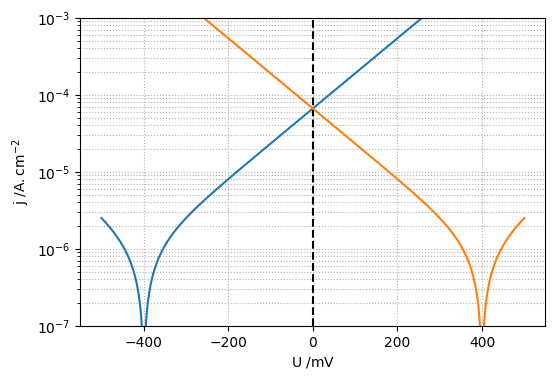

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid(which='minor', axis='y')
ax.set_xlabel(r'$U$ /mV', fontsize='medium')
ax.set_ylabel('$j$ /$A.cm^{-2}$', fontsize='medium')

ax.set_yscale('log')
ax.set_ylim(1e-7, 1e-3)
ax.axvline(x=0.0, color='k', ls='--', marker="")

I = np.abs(I_tafel1)
ax.plot(E, I, "C0-")

I = np.abs(I_tafel2)
ax.plot(E, I, "C1-")

name = 'Polarization_Curve-Galvanic'
for i in FORMATS:
    folder = '../Outputs/Plots/' + i + '/'
    ext = '.' + i
    fname = folder + name + ext
    fig.savefig(fname, dpi=300, format=i)

In [13]:
alpha_a = 0.5
alpha_c = 0.5
z=1.0
S=1.0
T=280.0
j0 = 1e-6
jla = j0 * 200
jlc = -j0 * 200

dOCV = 50.0
OCV1 = 0.0
OCV2 = OCV1 + dOCV
E = np.linspace(OCV1-100.0, OCV2+100, 1000_000)

OCV = OCV1
I_tafel1, Ia, Ic, *opt = skx.kinetics.buttler_volmer((E-OCV)/1000.0, j0, alpha_a, alpha_c, z,z, S, T)

OCV = OCV2
I_tafel2, Ia, Ic, *opt = skx.kinetics.buttler_volmer((E-OCV)/1000.0, j0, alpha_a, alpha_c, z,z, S, T)

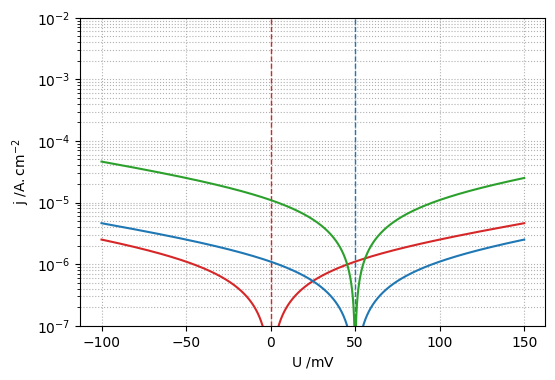

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid(which='minor', axis='y')
ax.set_xlabel(r'$U$ /mV', fontsize='medium')
ax.set_ylabel('$j$ /$A.cm^{-2}$', fontsize='medium')

ax.set_yscale('log')
ax.set_ylim(1e-7, 1e-2)
ax.axvline(x=OCV1, color='C3', ls='--', marker="", lw=1)
ax.axvline(x=OCV2, color='C0', ls='--', marker="", lw=1)

Ia = I_tafel1
ax.plot(E, np.abs(Ia), "C3-")

Ic = I_tafel2
ax.plot(E, np.abs(Ic), "C0-")

Ic = I_tafel2 * 10.0
ax.plot(E, np.abs(Ic), "C2-")



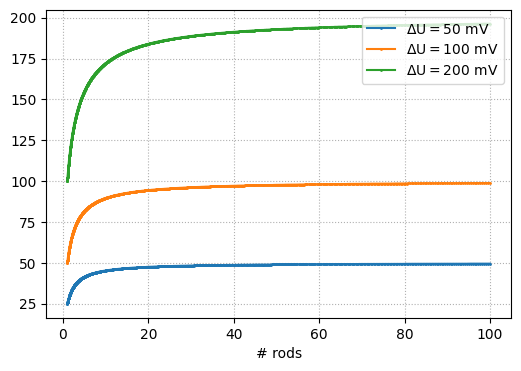

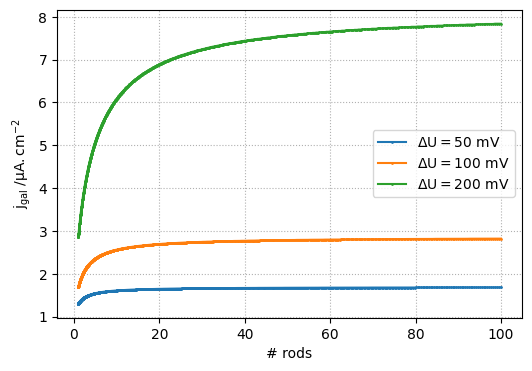

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'# rods', fontsize='medium')
fig_E_mixed = fig
ax_E_mixed = ax

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'# rods', fontsize='medium')
ax.set_ylabel(r'$j_{gal}$ /$\mu A.cm^{-2}$', fontsize='medium')
fig_I_gal = fig
ax_I_gal = ax

for dOCV in (50.0, 100.0, 200.0):
    OCV1 = 0.0
    OCV2 = OCV1 + dOCV
    E = np.linspace(OCV1-100.0, OCV2+100, 5000)
    
    S = np.logspace(0, 2, 1000)
    E_mixed = np.zeros(shape=S.shape, dtype="f8")
    Igal = np.zeros(shape=S.shape, dtype="f8")
    for i, in np.ndindex(S.shape):
        OCV = OCV1
        I_tafel1, Ia1, Ic1, *opt = skx.kinetics.buttler_volmer((E-OCV)/1000.0, j0, alpha_a, alpha_c, z,z, A=1.0, T=280.0)
        OCV = OCV2
        I_tafel2, Ia2, Ic2, *opt = skx.kinetics.buttler_volmer((E-OCV)/1000.0, j0, alpha_a, alpha_c, z,z, A=S[i], T=280.0)
        I = I_tafel1 + I_tafel2
        ix = np.argmin(np.abs(I))
        E_mixed[i] = E[ix]
        Igal[i] = Ia1[ix]
    
    fig, ax = fig_E_mixed, ax_E_mixed
    ax.plot(S, E_mixed, label = r"$\Delta U=$" + f"{dOCV:.0f} mV")
    ax.legend()
    
    fig, ax = fig_I_gal, ax_I_gal
    ax.plot(S, Igal*1e6, label = r"$\Delta U=$" + f"{dOCV:.0f} mV")
    ax.legend()